In [1]:
%run functions.ipynb

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print(
    "(1, 0) labels count in train test: {} {}".format(
        (np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 0)),
        (np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)),
    )
)
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [3]:
n_iter = 1
cv = 4
n_jobs = 3
scoring = 'roc_auc'

In [4]:
n_components = [50, 150, 300, 450, 600, 750]
logistic_params = {'C' : np.linspace(0.1, 1, 50), 'penalty' : ['l1'], 'solver' : ['liblinear']}
tree_params = {'n_estimators' : [100, 250, 500, 750], 'max_depth': [4, 6, 8], 'min_samples_leaf' : [20, 30]}

# PCA

In [5]:
dim_params = {'n_components' : n_components}

In [6]:
models_logit_pca = fit_dim_reduction_pipeline(PCA(), LogisticRegression(), dim_params, logistic_params, X_std_train, y_train, 
                                              n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_logit_pca = clf_print_scores(models_logit_pca, X_std_train, y_train, X_std_test, y_test)

Pipeline(memory=None,
     steps=[('dim', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=0.41224489795918373, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


,ROC AUC,Precision,Recall,F1
train,0.847,0.756,0.696,0.724
test,0.793,0.691,0.644,0.667


In [7]:
models_tree_pca = fit_dim_reduction_pipeline(PCA(), RandomForestClassifier(), dim_params, tree_params, X_std_train, y_train, 
                                             n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_tree_pca = clf_print_scores(models_tree_pca, X_std_train, y_train, X_std_test, y_test)

Pipeline(memory=None,
     steps=[('dim', PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            m...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


,ROC AUC,Precision,Recall,F1
train,0.921,0.970,0.336,0.499
test,0.769,1.000,0.077,0.143


# MLCC

In [8]:
mlcc_results = []
filenames = []
for filename in os.listdir('./mlcc_results/'):
    if filename.endswith('.RData'):
        mlcc_results.append(tuple(read_mlcc_result(filename, 726)))
        filenames.append(filename)
print(filenames)
#segmentation, mBIC, dimensionalities = read_mlcc_result(100, 969)

['output100_4_40_30.RData', 'output100_8_40_30.RData', 'output10_8_40_30.RData', 'output150_8_40_30.RData', 'output200_8_40_30.RData', 'output20_4_40_30.RData', 'output20_8_40_30.RData', 'output250_1_40_30.RData', 'output25_50_40_30.RData', 'output500_1_40_30.RData', 'output500_8_40_30.RData', 'output50_4_40_30.RData', 'output50_50_40_30.RData', 'output50_8_40_30.RData', 'output75_4_40_30.RData']


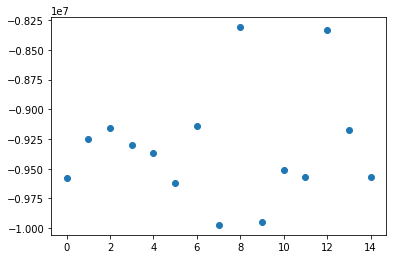

Highest mBIC is from output25_50_40_30.RData


In [9]:
mBICs = list(map(lambda x : x[1][0], mlcc_results))
plt.figure()
plt.scatter(np.arange(len(mBICs)), mBICs)
plt.show()
max_index = np.argmax(mBICs)
print('Highest mBIC is from {}'.format(filenames[max_index]))

In [10]:
segmentation = mlcc_results[max_index][0]
dimensionalities = mlcc_results[max_index][2]
print(segmentation, dimensionalities)
print(len(dimensionalities))

X_mlcc_train = apply_mlcc_dim_reduction(X_std_train, segmentation, dimensionalities)
X_mlcc_test = apply_mlcc_dim_reduction(X_std_test, segmentation, dimensionalities)

[16  4  4 ...  9  9  9] [ 6  7 13 35 42  9 36 25 13 17  9 40  6  4  4 26 42  4 12 16 12  7  6 12
  4]
25


In [11]:
logit_cv = RandomizedSearchCV(LogisticRegression(), cv=cv, scoring=scoring, n_iter=n_iter, n_jobs=n_jobs, iid=False, param_distributions=logistic_params) 
tree_cv = RandomizedSearchCV(RandomForestClassifier(), cv=cv, scoring=scoring, n_iter=n_iter, n_jobs=n_jobs, iid=False, param_distributions=tree_params) 

clf_logit = fit_clf_print_scores(logit_cv, X_mlcc_train, y_train, X_mlcc_test, y_test)
clf_forest = fit_clf_print_scores(tree_cv, X_mlcc_train, y_train, X_mlcc_test, y_test)

LogisticRegression(C=0.44897959183673475, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


,ROC AUC,Precision,Recall,F1
train,0.993,0.968,0.945,0.956
test,0.557,0.455,0.481,0.467


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


,ROC AUC,Precision,Recall,F1
train,0.914,0.881,0.689,0.773
test,0.706,0.730,0.260,0.383


# SPCA

In [5]:
dim_params = {'n_components' : n_components, 'threshold_val' : [0.01, 0.1, 0.5, 1, 3, 5, 10], 'threshold_mode': ['soft', 'hard', 'garrote'], 
              'max_iter': ['25', '50', '100', '250']}

In [ ]:
models_logit_spca = fit_dim_reduction_pipeline(SPCWrapper(), LogisticRegression(), dim_params, logistic_params, X_std_train, y_train, 
                                               n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_logit_spca = clf_print_scores(models_logit_spca, X_std_train, y_train, X_std_test, y_test)

In [ ]:
models_tree_spca = fit_dim_reduction_pipeline(SPCWrapper(), RandomForestClassifier(), dim_params, tree_params, X_std_train, y_train, 
                                              n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_tree_spca = clf_print_scores(models_tree_spca, X_std_train, y_train, X_std_test, y_test)

## PLS

In [ ]:
dim_params = {'n_components' : n_components}

In [ ]:
models_logit_pls = fit_dim_reduction_pipeline(PLSRegressionWrapper(), LogisticRegression(), dim_params, logistic_params, X_std_train, y_train, 
                                             n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_logit_pls = clf_print_scores(models_logit_pls, X_std_train, y_train, X_std_test, y_test)

In [ ]:
models_tree_pls = fit_dim_reduction_pipeline(PLSRegressionWrapper(), RandomForestClassifier(), dim_params, tree_params, X_std_train, y_train, 
                                             n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_tree_pls = clf_print_scores(models_tree_pls, X_std_train, y_train, X_std_test, y_test)